In [1]:
#    %pip install swig
#    %pip install -U gymnasium[classic_control,box2d,atari,accept-rom-license]
#    %pip install tensorflow
#    %pip install pygame

In [12]:
from functools import reduce
from collections import deque
from typing import Optional, Union
import tensorflow as tf
import numpy as np
import gymnasium as gym
import pygame, random, operator, math, os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

<h1> Clase Gap v0</h1>

In [13]:
class GapV0Env(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    metadata = {"render_modes": ["human", "pixel_array"], "render_fps": 5, "max_score": 100}
    def __init__(self, render_mode = "human"):
        assert render_mode is None or render_mode in ["human", "pixel_array"], "set render mode to either 'None', 'human' or 'pixel_array'"
        self.render_mode = render_mode
        self.screen_width, self.screen_height = 96, 300
        self.places = {x: p for (x, p) in zip([0,1,2,3,4,5], [(x/6 +1/12)*self.screen_width for x in [0,1,2,3,4,5]])}
        self.action_space = gym.spaces.discrete.Discrete(3)
        self.observation_space = gym.spaces.box.Box(0, 5, (2,))
        self.wall_separation = 50
        self.n_walls = (self.screen_height // self.wall_separation)
        self.walls, self.player_place, self.n_frames = None, None, None
        self.player_y_elevation = 25

    
    def _init_screen(self):
        if self.render_mode == "human":
            pygame.display.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height), pygame.SCALED)
        else:  # mode == "rgb_array"
            self.screen = pygame.Surface((self.screen_width, self.screen_height))
            
    def _handle_input(self):
        if self.render_mode == "human":
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    dead = True
    
    def _get_obs(self):
        return np.array([self.player_place, self.walls[-1]])

    def _get_reward(self, action):
        if self.player_place == self.walls[-1]:
            return 1 if action == 1 else -1
        distancia_izquierda = (self.player_place - self.walls[-1]) % 6
        distancia_derecha = ( self.walls[-1] - self.player_place) % 6        
        if distancia_izquierda < distancia_derecha:
            return 1 if action == 0 else -1
        elif distancia_derecha < distancia_izquierda:
            return 1 if action == 2 else -1
        else:
            return 1 if action in [0,2] else -1
        
    def _check_would_die(self, pos):
        return not self.walls[-1] == pos

    def reset(self):
        pygame.init()
        self._init_screen()
        self.player_place = random.choice([1,2,3,4])
        self.wall_shift, self.n_frames = 0, 0
        self.clock = pygame.time.Clock()
        self.walls = np.random.randint(0,6,(self.n_walls))
        self.score = 0
        return self._get_obs(), {}
    
    def step(self, action):
        assert action in [0,1,2], "Action does not belong to action space"
        assert self.walls is not None, "Call reset metod before step"
        reward = self._get_reward(action)
        self._handle_input()
        dead = False
        #mover el jugador a la nueva posicion segun la accion escogida
        self.player_place = (self.player_place + (action-1)) % 6
        
        #si los muros están totalmente desplazados
        if self.wall_shift >= self.wall_separation:
            #desplazamiento igual a cero, destruir ultimo muro y agregar el nuevo
            self.wall_shift = 0
            self.walls[1:] = self.walls[:-1];
            self.walls[0] = random.randint(0,5)
            
        #Bajar muros
        self.wall_shift += 10
        
        #comprobar si el jugador ha perdido
        if self.wall_shift >= self.wall_separation and self._check_would_die(self.player_place):
            dead = True
        self.score += 1
        
        #Si se ha muerto o se ha alcanzado la puntuacion maxima, se acaba el episodio
        terminated = self.score >= self.metadata["max_score"] or dead
        
        #Si el modo de renderizado es "human", renderizar a la velocidad establecida
        if self.render_mode == "human": self.clock.tick(self.metadata["render_fps"])
        return (self._get_obs(), reward, terminated, False, {})  

    def render(self):
        player_pos = self.places[self.player_place]
        s = pygame.Surface((self.screen_width, self.screen_height))
        s.fill('Black')
        self.screen.blit(s, (0,0))
        for i in range(self.walls.shape[0]):
            for j in range(6):
                if self.walls[i] != j:
                    s = pygame.Surface((self.screen_width/6, 2))
                    s.fill('White')
                    self.screen.blit(s, (j*(self.screen_width/6), self.wall_separation*i + self.wall_shift - self.player_y_elevation))
        s = pygame.Surface((2,2))
        s.fill('White')
        self.screen.blit(s, (player_pos-1, self.screen_height - self.player_y_elevation))
        

        if self.render_mode == "human":
            pygame.display.update()

        elif self.render_mode == "pixel_array":
            pixels = np.transpose(np.array(pygame.surfarray.pixels_green(self.screen)))//255
            return pixels


    def close(self):
        pygame.quit()

<h1>Clase Gap v1</h1>

In [14]:
class GapV1Env(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    metadata = {"render_modes": ["human", "pixel_array"], "render_fps": 30, "max_score": 700}
    def __init__(self, render_mode = "human"):
        assert render_mode is None or render_mode in ["human", "pixel_array"], "set render mode to either 'None', 'human' or 'pixel_array'"
        self.render_mode = render_mode
        self.screen_width, self.screen_height = 96, 100
        self.action_space = gym.spaces.discrete.Discrete(3)
        self.observation_space = gym.spaces.box.Box(0, 1, (3,))
        self.walls = None
        self.wall_separation = 50
        self.player_speed = 1/24
        self.mov_speed = self.player_speed * self.screen_width
        self.wall_speed = 10
        self.player_y_elevation = 25

    def _get_obs(self):
        state = np.zeros((3,), np.float64)
        state[:2] = self.walls[-1]
        state[2] = (self.player_pos / self.screen_width)
        return state
    
    def _populate_row(self, row):
        min_diff = 1/8
        a = np.random.random()
        b = np.random.random()
        
        while (abs(a - b) <= min_diff) or (abs(a+1-b)<=min_diff) or (abs(b+1-b)<=min_diff):
            b = np.random.random()
        self.walls[row] = np.array([a, b])
    
    def _check_would_die(self, pos):
        player_pos = pos/self.screen_width
        a, b = self.walls[-1, 0], self.walls[-1, 1]
        if a < b:
            return player_pos<a or player_pos>b
        else:
            return (player_pos>b and player_pos<a)
            
    def _get_new_pos(self, action):
        movement = (action-1)*self.mov_speed
        new_pos = self.player_pos + movement
        if new_pos < 0: new_pos = self.screen_width + new_pos
        if new_pos >= self.screen_width: new_pos = (new_pos - self.screen_width)
        return new_pos
    
    def _get_distances(self):
        a, b = self.walls[-1, 0], self.walls[-1, 1]
        rel_pos = self.player_pos / self.screen_width
        a_values = [(rel_pos-a) if rel_pos-a>0 else 2, (rel_pos + (1-a)),
                    (a - rel_pos) if a-rel_pos > 0 else 2, ((1-rel_pos) + a)]
        b_values = [(rel_pos-b) if rel_pos-b>0 else 2, (rel_pos + (1-b)),
                    (b - rel_pos) if b-rel_pos > 0 else 2, ((1-rel_pos) + b)]
        distance_a, action_a = min(a_values), (np.argmin(a_values) // 2) * 2
        distance_b, action_b = min(b_values), (np.argmin(b_values) // 2) * 2
        assert distance_a > 0
        assert distance_b > 0
        assert action_a in [0,2]
        assert action_b in [0,2]
        return distance_a, action_a, distance_b, action_b
        
    def _get_reward(self, action):
        if not self._check_would_die(self._get_new_pos(action)):
            #print("NO MORIRIA")
            return 1
        if (not self._check_would_die(self.player_pos)) and self._check_would_die(self._get_new_pos(action)):
            #print("SE SALE")
            return -1
        distance_a, action_a, distance_b, action_b = self._get_distances()
        if distance_a < distance_b:
            if action == action_a:
                #print("SE ACERCA AL HUECO 1")
                return 1
            else:
                #print("SE ALEJA DEL HUECO 1")
                return -1
        else:
            if action == action_b:
                #print("SE ACERCA AL HUECO 2")
                return 1 
            else:
                #print("SE ALEJA DEL HUECO 2")
                return -1
    
    def _init_screen(self):
        if self.render_mode == "human":
            pygame.display.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height), pygame.SCALED)
        else:
            self.screen = pygame.Surface((self.screen_width, self.screen_height))
    
    def _handle_input(self):
        if self.render_mode == "human":
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    dead = True        
    
    def reset(self):
        pygame.init()
        self._init_screen()
        self.player_pos = 24 + 4 * random.randint(0, 12)
        n_walls = (self.screen_height // self.wall_separation)
        self.walls = np.zeros((n_walls,2), dtype = np.float64)
        for i in range(self.walls.shape[0]):
            self._populate_row(i)
        self.wall_shift = 0
        self.clock = pygame.time.Clock()

        self.score = 0

        return self._get_obs(), {}

        
    def step(self, action):
        assert action in [0,1,2], "Action does not belong to action space"
        assert self.walls is not None, "Call reset metod before step"
        movement = (action-1)*self.mov_speed
        reward = self._get_reward(action)
        self._handle_input()
        dead = False

        #mover el jugador a la nueva posicion segun la accion escogida
        self.player_pos = self._get_new_pos(action)
        
        #si los muros están totalmente desplazados
        if self.wall_shift >= self.wall_separation:
            #hacer desplazamiento igual a cero, destruir ultimo muro y añadir el nuevo
            self.wall_shift = 0
            self.walls[1:] = self.walls[:-1];
            self._populate_row(0)
        
        #BAJAR MUROS
        self.wall_shift += 2

        #comprobar si el jugador ha perdido
        if self.wall_shift >= self.wall_separation and self._check_would_die(self.player_pos):
            dead = True

        self.score += 1
        #Si se ha muerto o se ha alcanzado la puntuacion maxima, se acaba el episodio
        terminated = self.score >= self.metadata["max_score"] or dead

        #Si el modo de renderizado es "human", renderizar a la velocidad establecida
        if self.render_mode == "human": self.clock.tick(self.metadata["render_fps"])

        return (self._get_obs(), reward, terminated, False, {})    

    def render(self):

        s = pygame.Surface((self.screen_width, self.screen_height))
        s.fill('Black')
        self.screen.blit(s, (0,0))
        for i in range(self.walls.shape[0]):
            a, b = self.walls[i, 0], self.walls[i, 1]
            if a < b:
                s1 = pygame.Surface((a*self.screen_width, 2))
                s2 = pygame.Surface((self.screen_width-b*self.screen_width, 2))
                s1.fill('White')
                s2.fill('White')
                self.screen.blit(s1, (0, self.wall_separation*i 
                                      + self.wall_shift - self.player_y_elevation))
                self.screen.blit(s2, (b*self.screen_width, self.wall_separation*i 
                                      + self.wall_shift - self.player_y_elevation))
            else:
                s = pygame.Surface((abs(a-b)*self.screen_width, 2))
                s.fill('White')
                self.screen.blit(s, (b*self.screen_width, self.wall_separation*i
                                     + self.wall_shift - self.player_y_elevation))
        s = pygame.Surface((2,2))
        s.fill('White')
        self.screen.blit(s, (self.player_pos-1, self.screen_height - self.player_y_elevation))
        

        if self.render_mode == "human":
            pygame.display.update()
            
        elif self.render_mode == "pixel_array":
            pixels = np.transpose(np.array(pygame.surfarray.pixels_green(self.screen)))//255
            return pixels

    def close(self):
        pygame.quit()





<h1>Agente Dueling Double Deep Q-network<h1>

In [50]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN
    
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done)) #MODIFICADO
    return next_state, reward, done, info #MODIFICADO

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5) #MODIFICADO
    ]  # [states, actions, rewards, next_states, dones]

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
    runs = 1.0 - dones  # episode is not done
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def trainAgent(n_episodes = 2500, savename = "model_default.h5"):
    best_score = max(rewards)-1 if rewards else 0
    for episode in range(len(rewards), len(rewards) + n_episodes):
        obs, _ = env.reset()
        for step in range(env.metadata["max_score"]): #MODIFICADO
            epsilon = max(1 - episode / n_eps_until_min_epsilon, min_epsilon)
            obs, reward, done, info = play_one_step(env, obs, epsilon) #MODIFICADO
            if done:
                break
        print(f"\rEpisode: {episode + 1}, Score: {step + 1}, eps: {epsilon:.3f}, best score: {best_score+1}   ", end = "")
        rewards.append(step)
        
        if step >= best_score:
            best_weights = model.get_weights()
            model.save_weights(savename)
            best_score = step
    
        if episode > 50:
            training_step(batch_size)
            if episode % 50 == 0:
                target.set_weights(model.get_weights())
                
    model.set_weights(best_weights)

In [56]:
def trainAgent(n_episodes = 2500, savename = "model_default.h5"):

    def modified_sigmoid(x, large_number):
            return 1-0.0003*x if x < large_number else max(1-(x-large_number)/50, 0.1)
        
    best_score = max(rewards)-1 if rewards else 0
    for episode in range(len(rewards), len(rewards) + n_episodes):
        obs, _ = env.reset()
        for step in range(env.metadata["max_score"]): #MODIFICADO
            epsilon = modified_sigmoid(episode, n_eps_until_min_epsilon)
            obs, reward, done, info = play_one_step(env, obs, epsilon) #MODIFICADO
            if done:
                break
        print(f"\rEpisode: {episode + 1}, Score: {step + 1}, eps: {epsilon:.3f}, best score: {best_score+1}   ", end = "")
        rewards.append(step)
        
        if step >= best_score:
            best_weights = model.get_weights()
            model.save_weights(savename)
            best_score = step
    
        if episode > 50:
            training_step(batch_size)
            if episode % 50 == 0:
                target.set_weights(model.get_weights())
                
    model.set_weights(best_weights)


<h2>Entrenamiento de Gap v0</h2>

In [52]:
#HIPERPARAMETROS
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
hidden_layers_size = (64, 64)
n_eps_until_min_epsilon = 600
min_epsilon = 0.01
loss_fn = tf.keras.losses.mean_squared_error
replay_max_lenght = 2000

In [53]:
#DEFINICION DEL MODELO USADO API FUNCIONAL
n_inputs, n_outputs = 2, 3
input_states = tf.keras.layers.Input(shape=[n_inputs])
hidden1 = tf.keras.layers.Dense(hidden_layers_size[0], activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(hidden_layers_size[1], activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages



In [54]:
#INICIALIZACION DE VARIABLES
env = GapV0Env(render_mode = None)
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])
target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights
rewards = []
best_score = 0
replay_buffer = deque(maxlen=replay_max_lenght)

In [76]:
t0 = time.perf_counter()
trainAgent(n_episodes = 800, savename = "afer")
t1 = time.perf_counter()
print(f"\nTiempo transcurrido: {t1-t0:.2f}s")

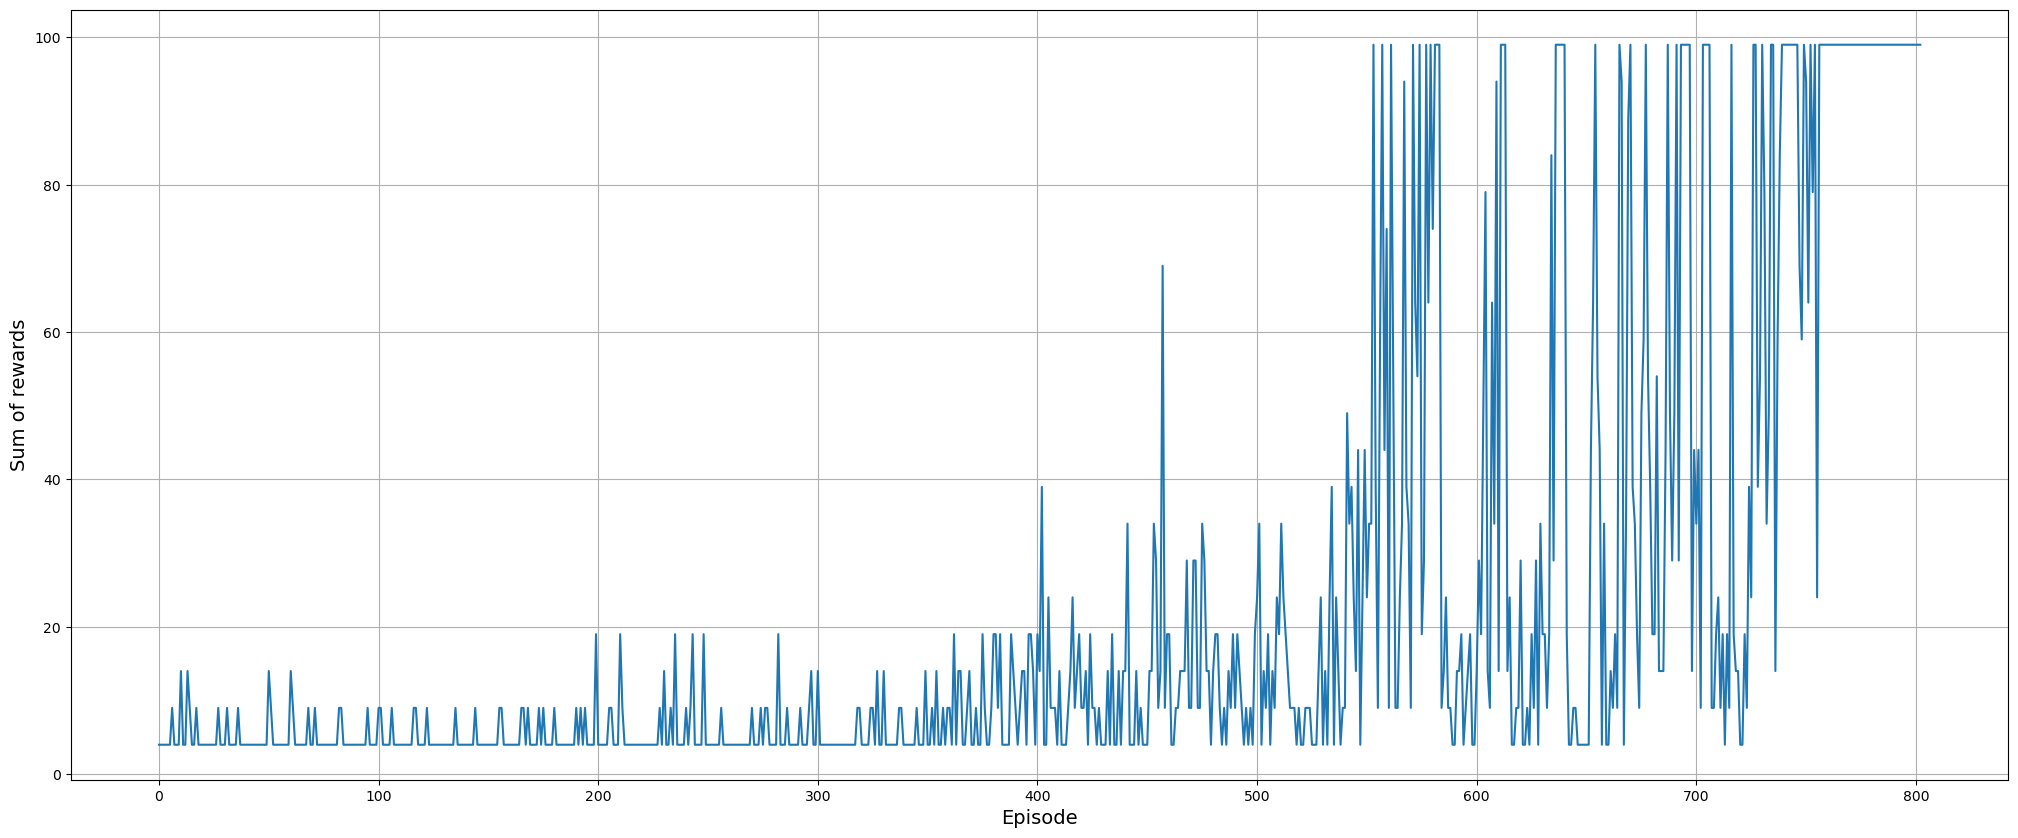

In [56]:
import matplotlib.pyplot as plt
# extra code – this cell plots the learning curve
plt.figure(figsize=(25, 10))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

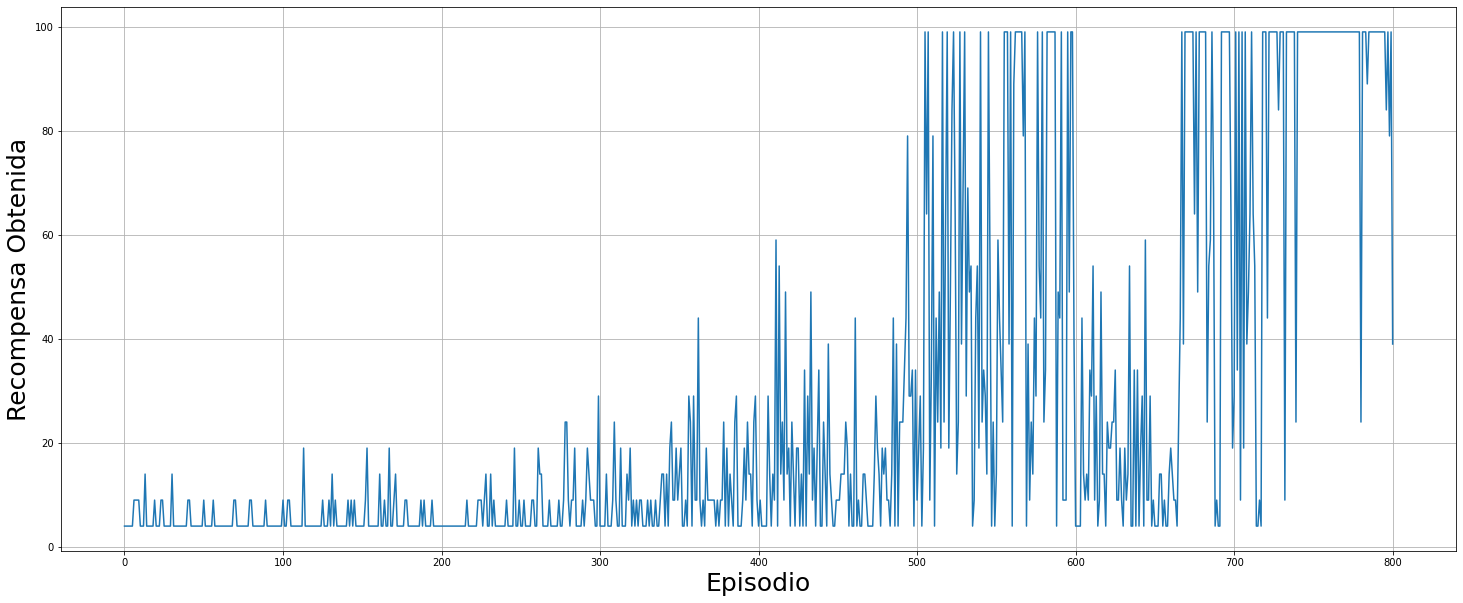

In [56]:
import matplotlib.pyplot as plt
# extra code – this cell plots the learning curve
plt.figure(figsize=(25, 10))
plt.plot(rewards)
plt.xlabel("Episodio", fontsize=25)
plt.ylabel("Recompensa Obtenida", fontsize=25)
plt.grid(True)
plt.show()

<h2>Entrenamiento de Gap v1</h2>

In [66]:
#HIPERPARAMETROS
batch_size = 100
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
hidden_layers_size = (64, 64)
n_eps_until_min_epsilon = 1300
min_epsilon = 0.1
loss_fn = tf.keras.losses.mean_squared_error
replay_max_lenght = 2000

In [67]:

#DEFINICION DEL MODELO USADO API FUNCIONAL
n_inputs, n_outputs = 3, 3
input_states = tf.keras.layers.Input(shape=[n_inputs])
hidden1 = tf.keras.layers.Dense(hidden_layers_size[0], activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(hidden_layers_size[1], activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages



In [68]:
#INICIALIZACION DE VARIABLES
env = GapV1Env(render_mode = None)
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])
target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights
rewards = []
best_score = 0
replay_buffer = deque(maxlen=replay_max_lenght)

In [63]:
t0 = time.perf_counter()
trainAgent(n_episodes = 1500, savename = "final.h5")
t1 = time.perf_counter()
print(f"\nTiempo transcurrido: {t1-t0:.2f}s")

Episode: 2500, Score: 175, eps: 0.100, best score: 700   
Tiempo transcurrido: 2370.95s


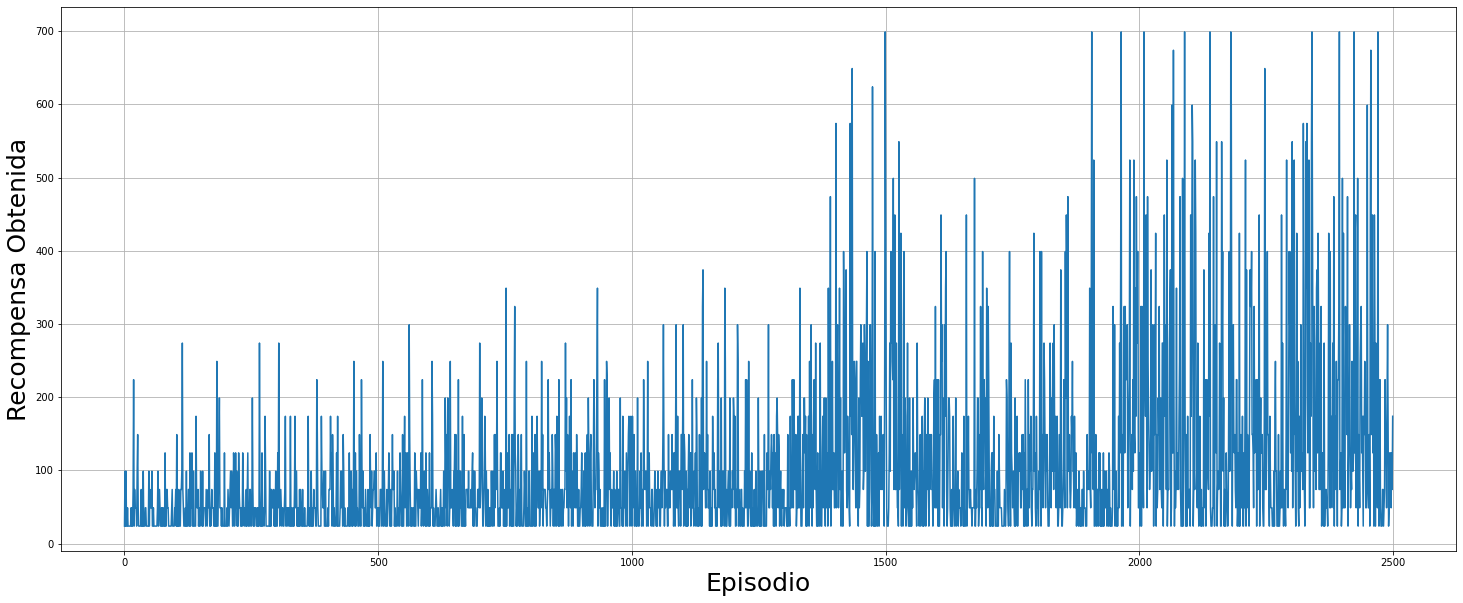

In [64]:
import matplotlib.pyplot as plt
# extra code – this cell plots the learning curve
plt.figure(figsize=(25, 10))
plt.plot(rewards)
plt.xlabel("Episodio", fontsize=25)
plt.ylabel("Recompensa Obtenida", fontsize=25)
plt.grid(True)
plt.show()

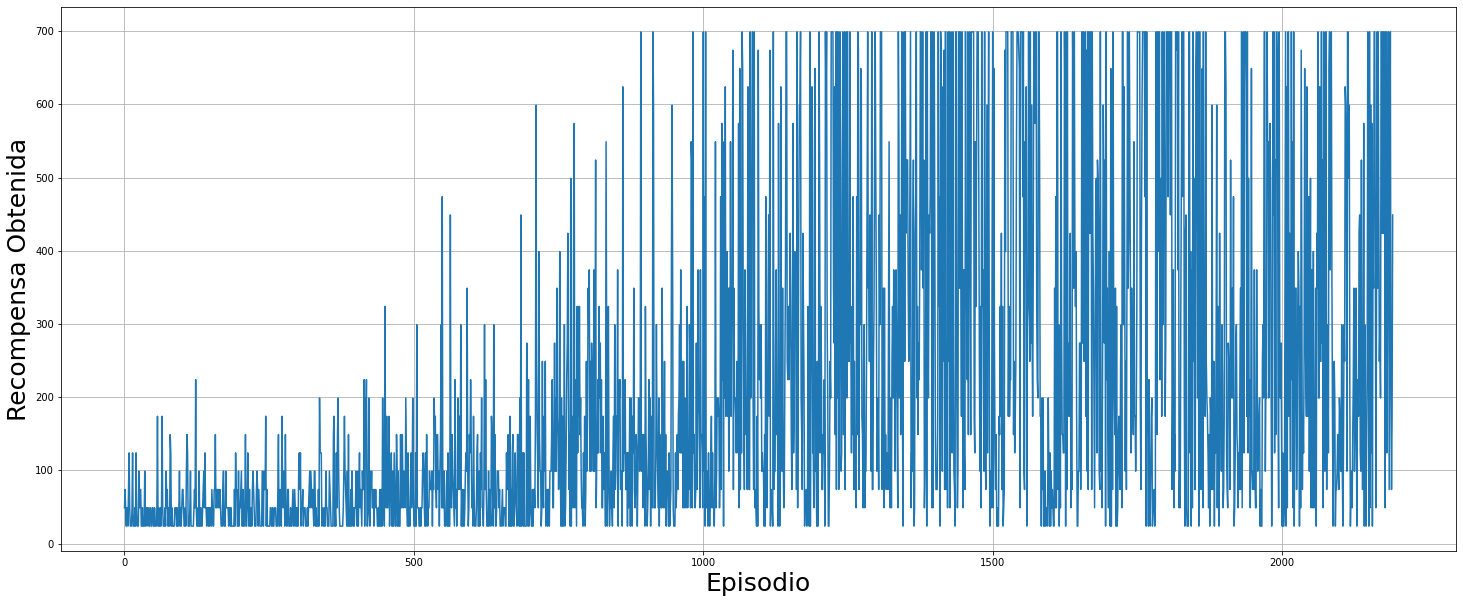

In [51]:
import matplotlib.pyplot as plt
# extra code – this cell plots the learning curve
plt.figure(figsize=(25, 10))
plt.plot(rewards)
plt.xlabel("Episodio", fontsize=25)
plt.ylabel("Recompensa Obtenida", fontsize=25)
plt.grid(True)
plt.show()

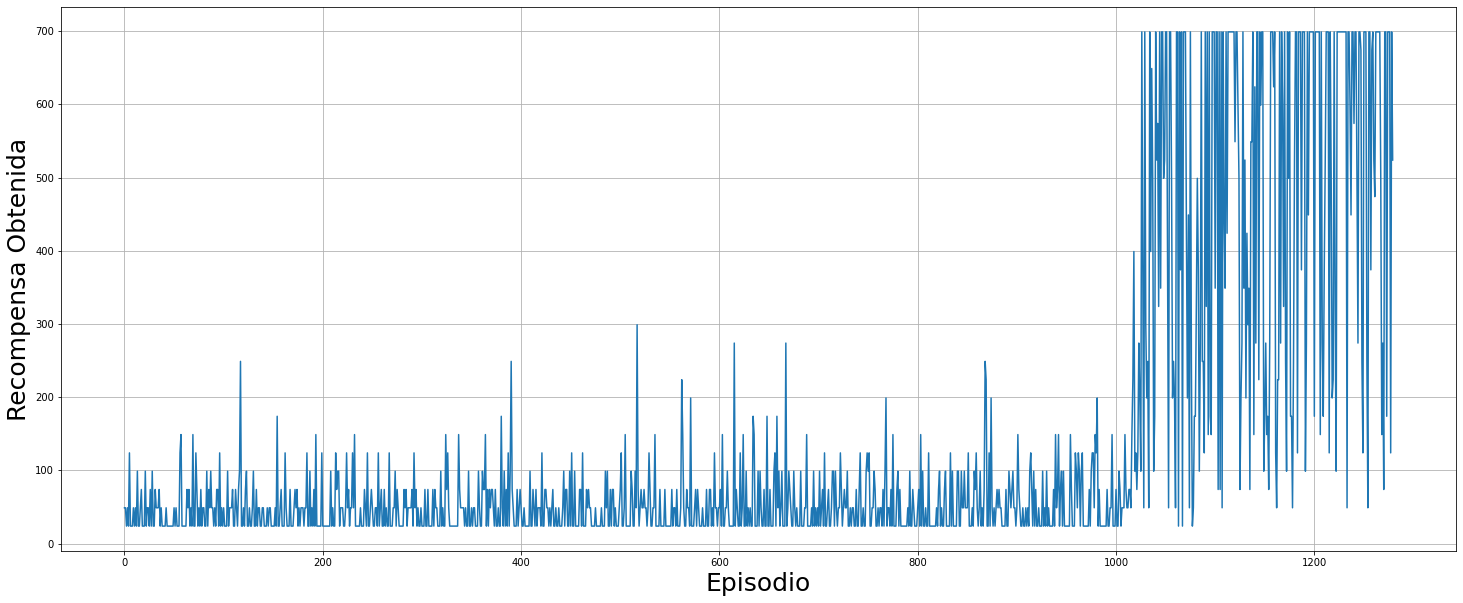

In [40]:
import matplotlib.pyplot as plt
# extra code – this cell plots the learning curve
plt.figure(figsize=(25, 10))
plt.plot(rewards[:1280])
plt.xlabel("Episodio", fontsize=25)
plt.ylabel("Recompensa Obtenida", fontsize=25)
plt.grid(True)
plt.show()

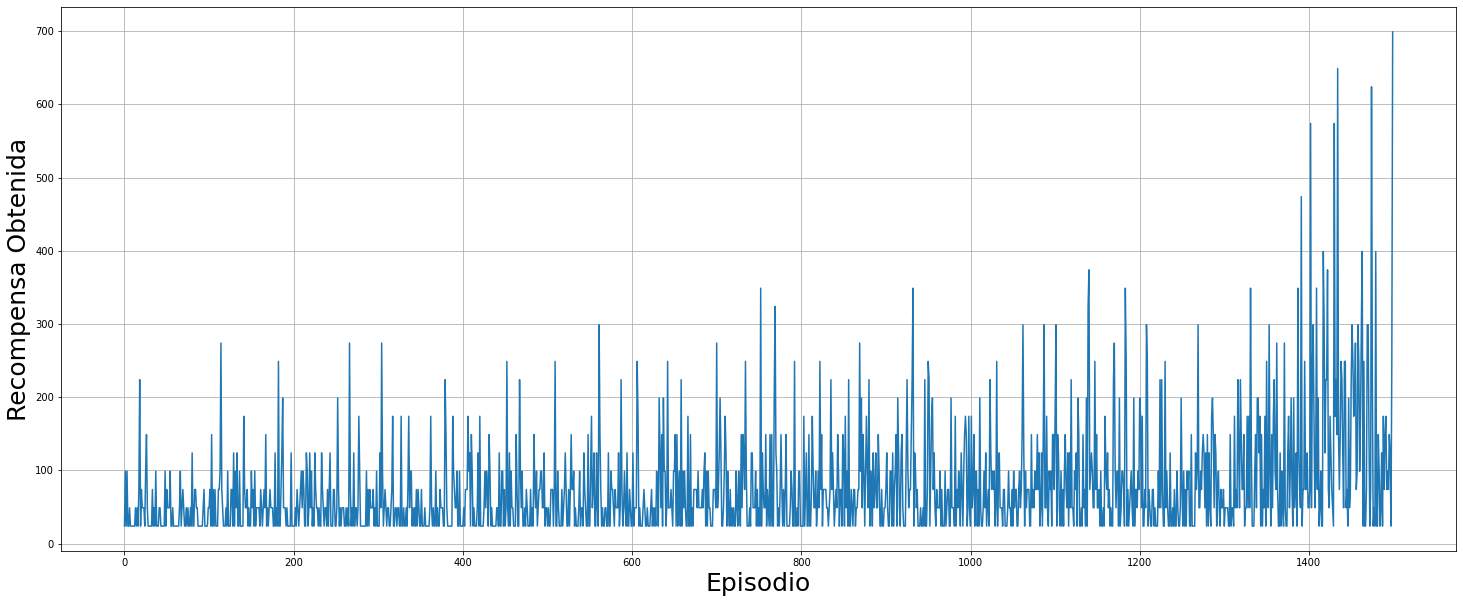

In [62]:
import matplotlib.pyplot as plt
# extra code – this cell plots the learning curve
plt.figure(figsize=(25, 10))
plt.plot(rewards)
plt.xlabel("Episodio", fontsize=25)
plt.ylabel("Recompensa Obtenida", fontsize=25)
plt.grid(True)
plt.show()

<h1>Visualización y medición del rendimiento de los modelos</h1>

In [70]:
def playModel(env, model, episodes, verbose= False):
    scores = np.zeros((episodes,))
    done = False
    for e in range(1, episodes+1):
        state, _ = env.reset()
        env.render()
        tr = 0
        while not done:            
            action = model.predict(np.array([state]).reshape((1,state.size)),
                                   verbose=0)[0].argmax() if model else env.action_space.sample()
            if verbose: print("-------------------------")
            if verbose: print("State:", state)
            #if verbose: print("Q values:", actions[0])
            #action = random.choice(env.getGoodActions())
            state, reward, done, _, _ = env.step(action)
            if verbose:print(f"Action chosen: {action}, Reward: {reward}")
            env.render()
            tr += 1
            if done:
                done = False
                scores[e-1] = tr
                print(f"episode: {e}, score: {tr}")
                break

    env.close()
    print("Average score: {}".format(np.mean(scores)))

In [77]:
playModel(GapV1Env(render_mode = None), model, 200, verbose = False)

In [79]:
playModel(GapV1Env(render_mode = "human"), model, 10, verbose = True)

<h2>Cargar a partir de archivos modelo entrenado y recompensas</h2>

In [74]:
import pickle
model.load_weights("model.h5")
target = tf.keras.models.clone_model(model)
with open('rewards.pickle', 'rb') as file:
    rewards = pickle.load(file)

<h2>Guardar como archivos el modelo entrenado y recompensas</h2>

In [41]:
import pickle
with open('rewards.pickle', 'wb') as file:
    pickle.dump(rewards, file)
model.save_weights("model.h5")